In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')
    
from tumor_data_processor import * 
from tumor_data_processor_2 import * 
from lengths_data_processor import *

In [3]:
data = pd.read_csv('datasets/P6.Inform/I062.033.WGS.Tumor_events.txt', sep='\t', header=None)

data

,0,1,2,3,4,5,6,7,8,9
0,P6.Rec7,"chr1:104,172,098-104,329,533",CN Loss,157436,p21.1,100.000000,-0.310519,NaN,6,9
1,P6.Rec7,"chr1:145,295,296-147,829,922",CN Loss,2534627,q21.1 - q21.2,69.986420,-0.214300,NaN,66,50
2,P6.Rec7,"chr1:149,849,729-151,918,075",CN Loss,2068347,q21.2 - q21.3,18.702819,-0.230841,NaN,63,78
3,P6.Rec7,"chr1:216,006,715-217,359,018",CN Gain,1352304,q41,6.679050,0.250782,NaN,40,3
4,P6.Rec7,"chr1:222,719,682-223,285,248",CN Gain,565567,q41,2.118055,0.242581,NaN,17,9
...,...,...,...,...,...,...,...,...,...,...
2087,P8.P.PreCx,"chr21:39,209,562-48,129,895",CN Gain,8920334,q22.13 - q22.3,17.460727,0.518459,NaN,283,168
2088,P8.P.PreCx,"chr22:16,155,104-16,278,767",CN Gain,123664,q11.1,100.000000,0.391192,NaN,5,7
2089,P8.P.PreCx,"chr22:16,447,404-51,304,566",CN Loss,34857163,q11.1 - q13.33,41.305718,-0.769570,NaN,1102,641
2090,P8.P.PreCx,"chrX:114,962,346-115,009,121",CN Loss,46776,q23,100.000000,-0.785339,NaN,6,2


In [4]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [5]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [6]:
# set copy number values from events to current bin
def update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_cn):
    
    # if event starts before bin start and ends somewhere after or at bin start
    if event_start < bin_start and event_end >= bin_start:
        update_start = 0
        
        # if event ends somewhere in bin
        if event_end < bin_end:
            update_end = event_end - bin_start + 1
            
        # if event ends after bin end
        else:
            update_end = bin_end
            
        _bin[update_start:update_end] = event_cn
        
    # if event starts before or at bin start and ends after bin end
    elif event_start <= bin_end and event_end >= bin_end:
        update_end = bin_end
        
        # if event starts somewhere in bin
        if event_start > bin_start:
            update_start = event_start - bin_start + 1
            
        # if event starts before bin start
        else:
            update_start = 0
            
        _bin[update_start:update_end] = event_cn
        
    # if events starts and ends somewhere inside bin
    elif event_start >= bin_start and event_end < bin_end:
        update_start = event_start - bin_start + 1
        update_end = event_end - bin_start + 1
        
        _bin[update_start:update_end] = event_cn
    

# split one chromosome to bigger units - bins, default bin size = 30000 bases
def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    
    # iteration over chromosome length by steps of size bin length
    for base in range(0, chromosome_len, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        # initialize bin values
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len
        
        # iterate through cnv events
        for index, row in chromosome_data.iterrows():
            event_start = row['Start']
            event_end = row['End']
            event_copy_number = row['Copy Number']
            
            update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_copy_number)
        
        # counting average of bases cn values in current bin
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [7]:
def plot_bins(bins):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='k')
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

In [8]:
def scatter_bins(bins):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(range(len(bins)), bins, c='k', s=8)
   
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))

In [9]:
# list holding names of chromosomes
chromosome_names = [str(_chr) for _chr in range(1, 23)]
chromosome_names.extend(['X', 'Y'])

chromosome_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 'X',
 'Y']

In [10]:
# split all chromosomes to bins (not X and Y for while)
def split_genome_to_bins(data):
    
    # bins will be stored in 2-d list (every sublist represents bins of one chromosome)
    bins = []
    
    # iterate through chromosome names except X and Y
    for _chr in chromosome_names[:-2]:
        
        # filter events of current chromosome
        chr_data = data[data['Chromosome'] == _chr]
        
        # length of current chromosome
        chr_len = lengths.loc[[_chr]]['Length'].item()
        
        # split current chromosome to bins
        chr_bins = split_chromosome_to_bins(chr_data, chr_len)
        
        # add current chromosome bins to list
        bins.append(chr_bins)
        
    return bins

In [11]:
# flatten 2-d array
def flatten_bins(bins):
    return [value for _chr in bins for value in _chr]

In [12]:
# count areas that bins with deviated CN creates between its records and axis - y = 2
def count_chromosome_area(chromosome_bins):
    area = 0
    for _bin in chromosome_bins:
        area += abs(_bin - 2)
        
    return area

In [13]:
# count absolute areas of all chromosomes
def count_genome_areas(bins):
    
    # areas will be stored in 1-d list (every item represents area of one chromosome)
    areas = []
    for _chr in bins:
        chr_area = count_chromosome_area(_chr)
        areas.append(chr_area)
        
    return areas

In [14]:
def visualize_areas_bar(areas, ylim=None):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(chromosome_names[:-2], areas)
    ax.set_ylim(ylim)

In [15]:
# count relative areas of chromosomes against their lengths
def count_relative_areas(areas, bins):
    relative_areas = []
    for idx, area in enumerate(areas):
        
        # length (in bins) of current chromosome
        chr_len = len(bins[idx])
        
        # count relative area
        relative_area = area / chr_len
        relative_areas.append(relative_area)
        
    return relative_areas

In [16]:
# count rate of bases with deviated CN values
def count_cnv_rate(data):
    
    # count length of all chromosomes in genome
    genome_length = lengths['Length'].sum(axis=0)
    
    # count sum of events lengths
    cnv_events_length = data['Length'].sum(axis=0)
    
    # return CNV rate of genome
    return cnv_events_length / genome_length

In [17]:
from collections import Counter

In [18]:
def intersection(s1, s2) : 
  
    # Find the intersection of the two sets  
    intersect = list((Counter(s1) & Counter(s2)).elements())

    return intersect


def jaccard(bins1, bins2):
    # Sizes of both the sets  
    size1 = len(bins1)
    size2 = len(bins2)  
  
    # Get the intersection set  
    intersect = intersection(bins1, bins2)
  
    # Size of the intersection set  
    size_in = len(intersect)
  
    # Calculate the Jaccard index  
    # using the formula  
    jaccard_in = size_in  / (size1 + size2 - size_in)  
  
    # Return the Jaccard index  
    return jaccard_in

In [19]:
import os

In [20]:
def read_files_test(directory_path):
    for filename in  os.listdir(directory_path):
        if filename.endswith(".txt"):
            relative_path = os.path.join(directory_path, filename)
            print(relative_path)

In [21]:
read_files_test('datasets/P6.Inform')

datasets/P6.Inform\I062.007.WGS.Pre_events.txt
datasets/P6.Inform\I062.007.WGS.Tumor_events.txt
datasets/P6.Inform\I062.015.WGS.Tumor_events.txt
datasets/P6.Inform\I062.022.WGS.Tumor_events.txt
datasets/P6.Inform\I062.033.WGS.Tumor_events.txt


In [22]:
def read_tumors(directory_path):
    tumors = []
    for filename in os.listdir(directory_path)[:-1]:
         if filename.endswith(".txt"):
            relative_path = os.path.join(directory_path, filename)
            data = pd.read_csv(relative_path, sep='\t', comment='#')
            data = process_tumor_data(data)
            
            tumors.append(data)
    
    filename = os.listdir(directory_path)[-1]
    relative_path = os.path.join(directory_path, filename)
    data = pd.read_csv(relative_path, sep='\t', header=None)
    data = process_tumor_data_2(data)
    tumors.append(data)
    
    return tumors

In [23]:
tumors = read_tumors('datasets\P6.Inform')

tumors

[    Chromosome  Copy Number   Length     Start       End
 0            1            1   745088   2789792   3534879
 1            1            3  1235765   9453839  10689603
 2            1            3  1305427  15793573  17098999
 3            1            3  1505877  28045550  29551426
 4            1            3   793193  32425081  33218273
 ..         ...          ...      ...       ...       ...
 98          21            3   361580  10265852  10627431
 100         22            1   235248  18636876  18872123
 101         22            3   369487  21665277  22034763
 102         22            3   426659  31774440  32201098
 103         22            1  1147816  48918773  50066588
 
 [98 rows x 5 columns],
     Chromosome  Copy Number    Length      Start        End
 1            1            3   2482505   85008845   87491349
 2            1            3   7563961  113613048  121177008
 4            1            3   1866103  144014595  145880697
 5            1            3   268

In [24]:
def split_tumors_to_bins(tumors):
    tumors_bins = []
    for tumor in tumors:
        tumor_bins = split_genome_to_bins(tumor)
        tumors_bins.append(tumor_bins)
    
    return tumors_bins

In [25]:
tumors_bins = split_tumors_to_bins(tumors)

[[[2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0,
   1.9931,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.1706666666666667,
   2.0,
   2.0,
   2.0,
   2.0,
   2.0

In [26]:
def flatten_tumors_bins(tumors_bins):
    flattened_tumors_bins = []
    for tumor_bins in tumors_bins:
        flattened_bins = flatten_bins(tumor_bins)
        flattened_tumors_bins.append(flattened_bins)
        
    return flattened_tumors_bins

In [27]:
flattened_tumors_bins = flatten_tumors_bins(tumors_bins)

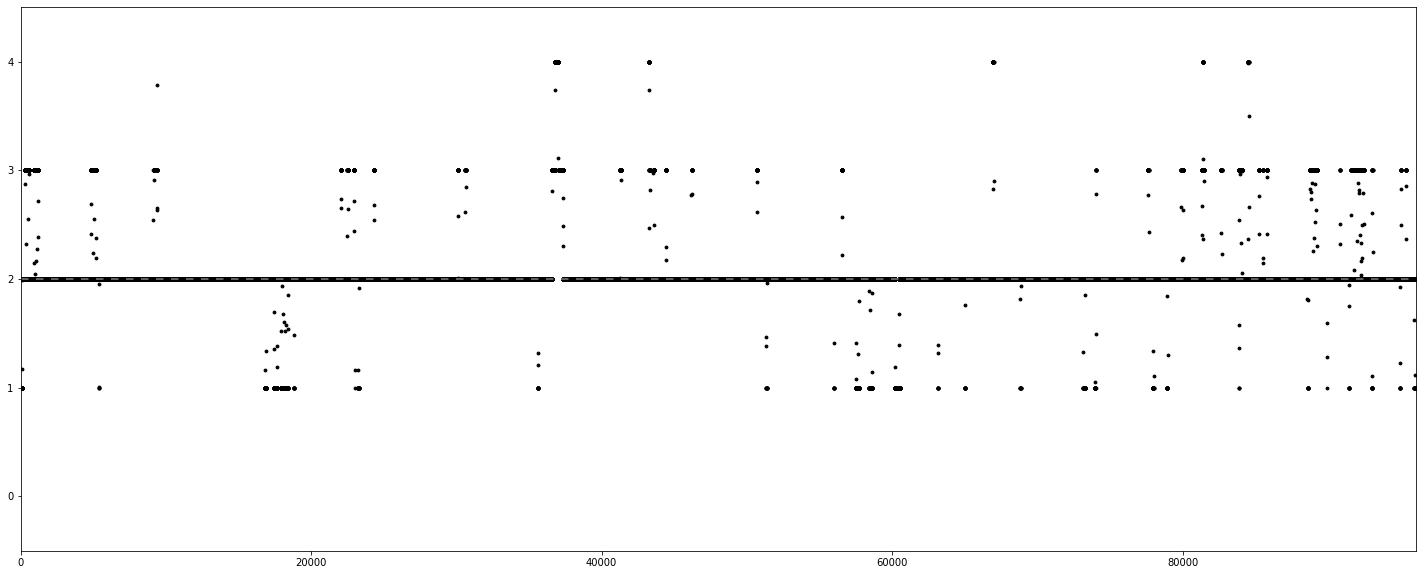

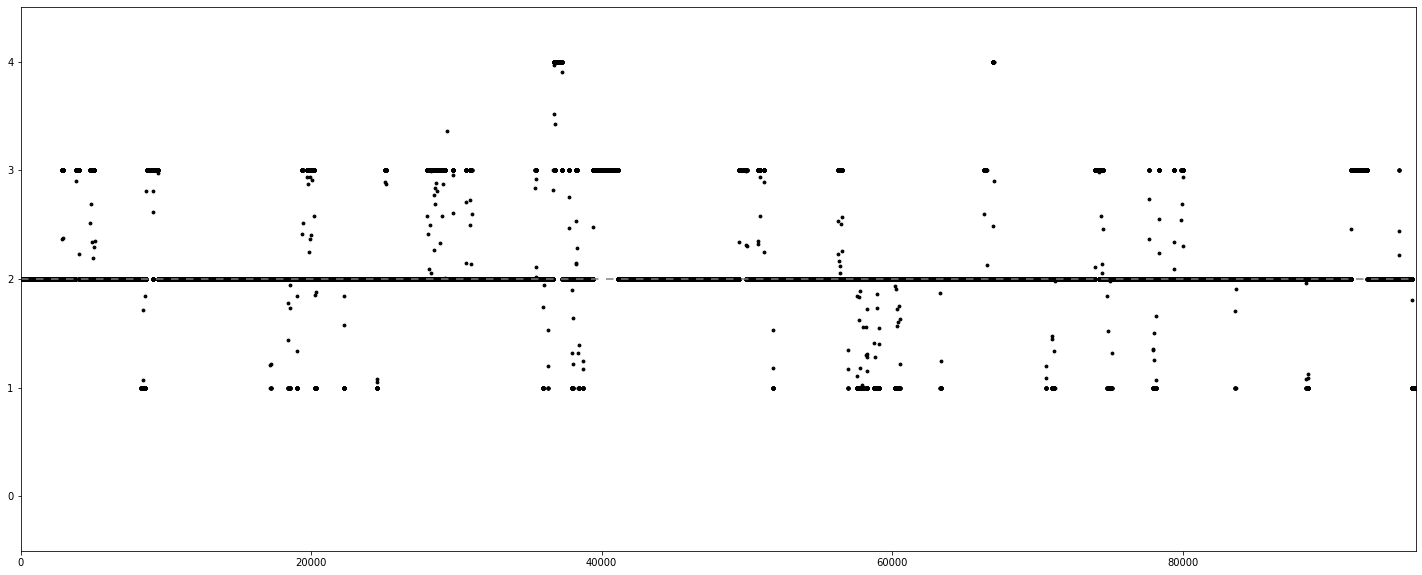

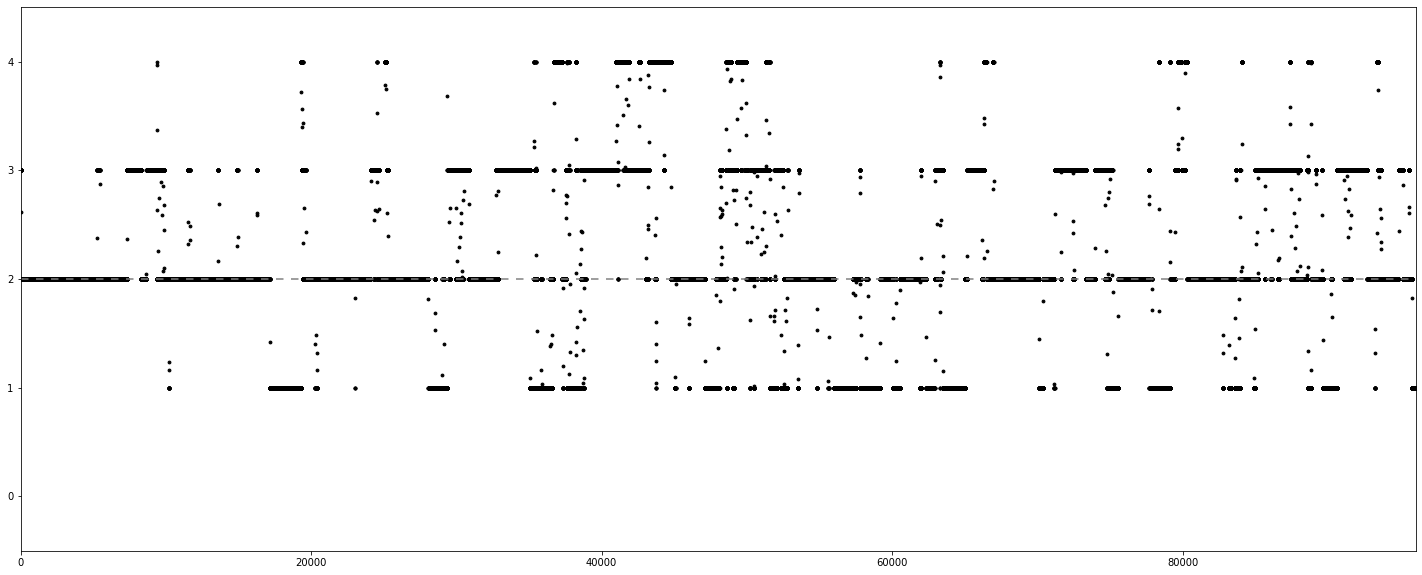

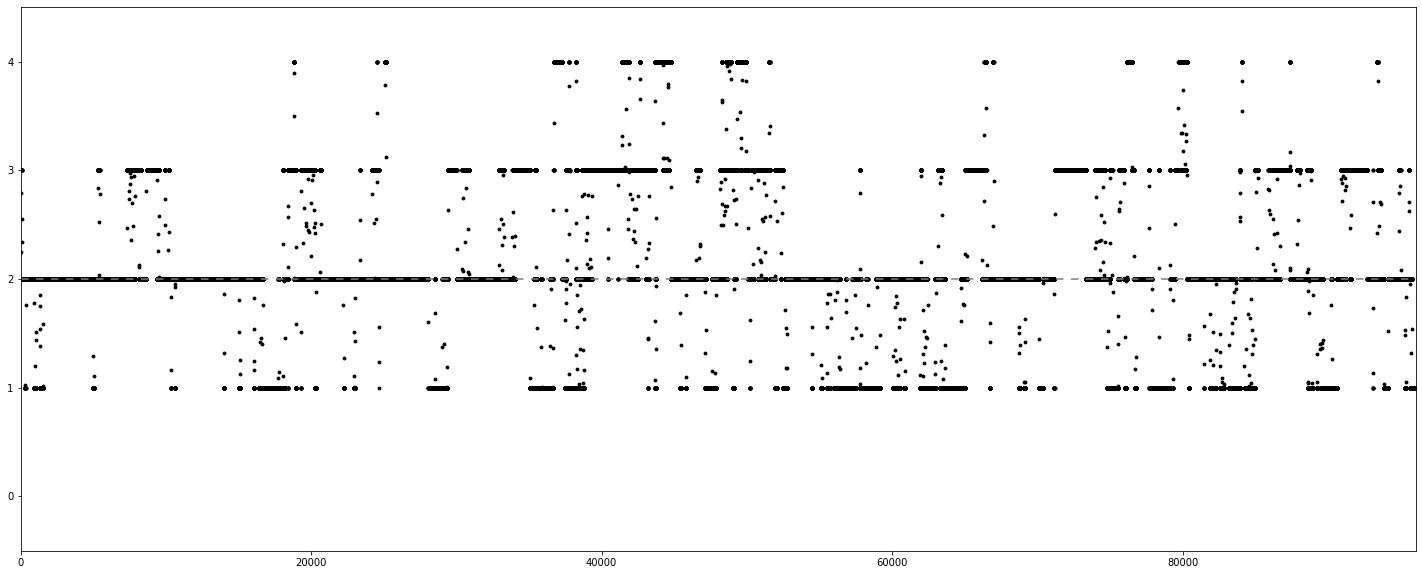

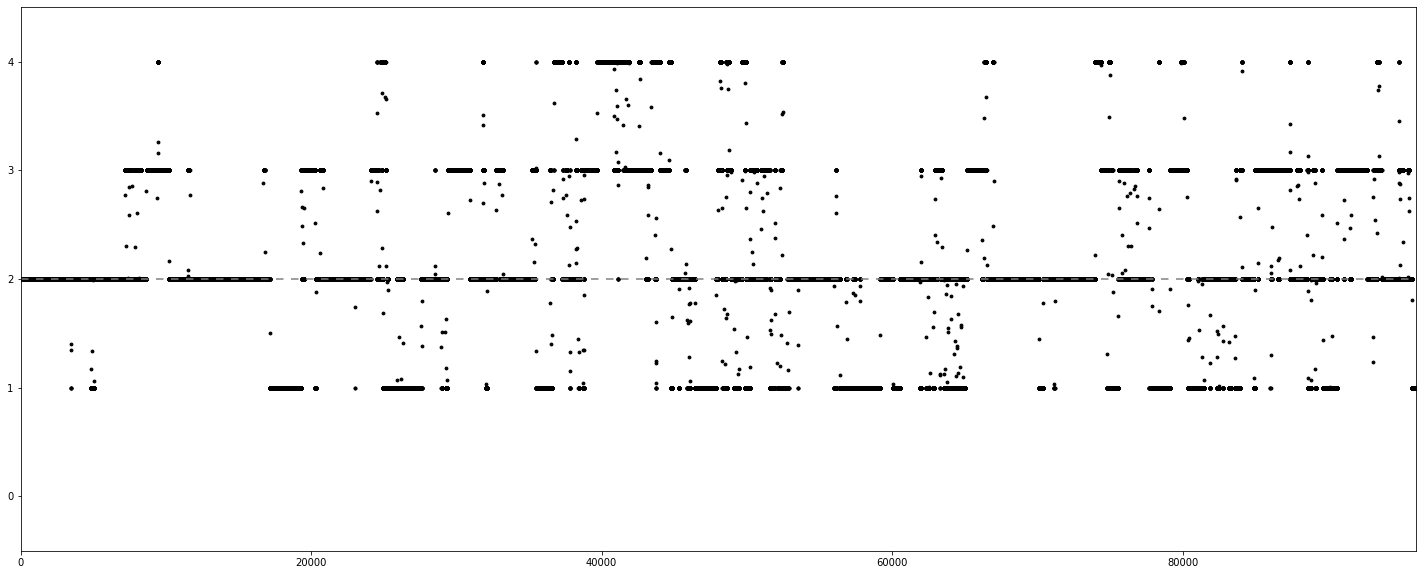

In [28]:
for flattened_bins in flattened_tumors_bins:
    scatter_bins(flattened_bins)

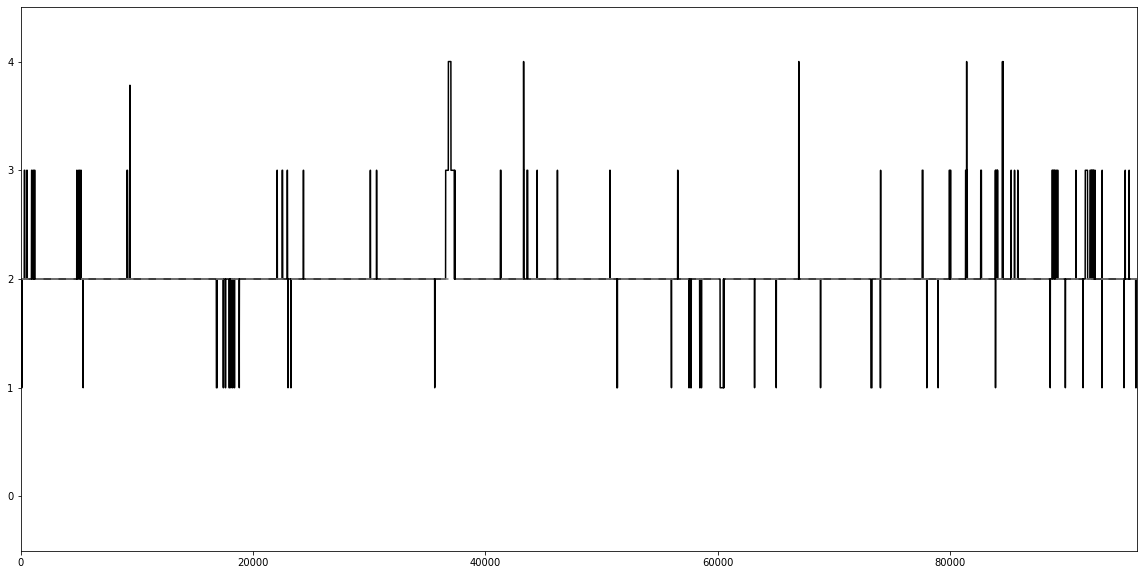

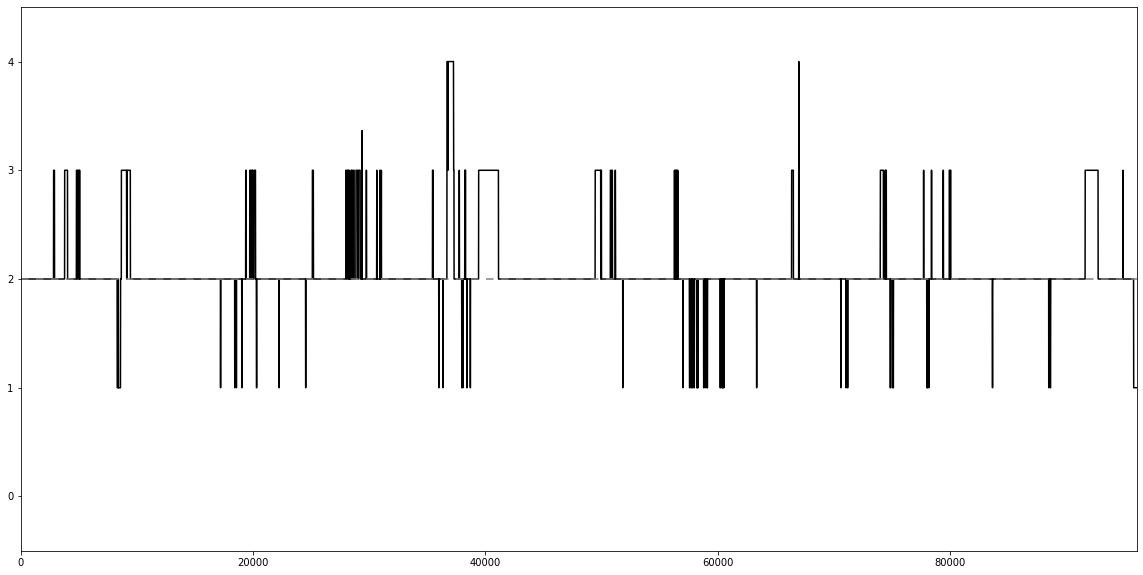

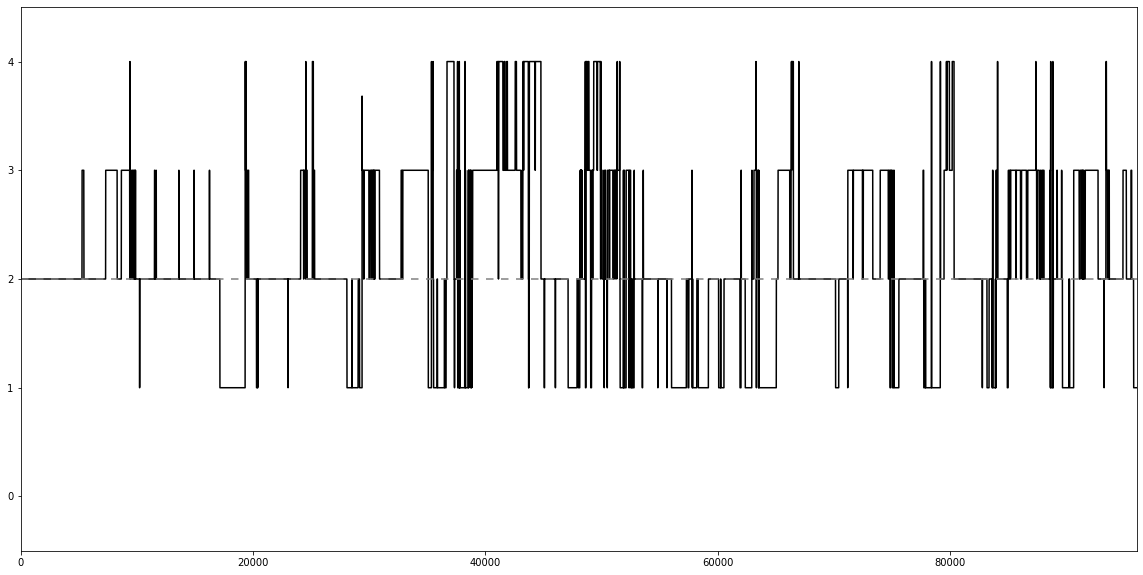

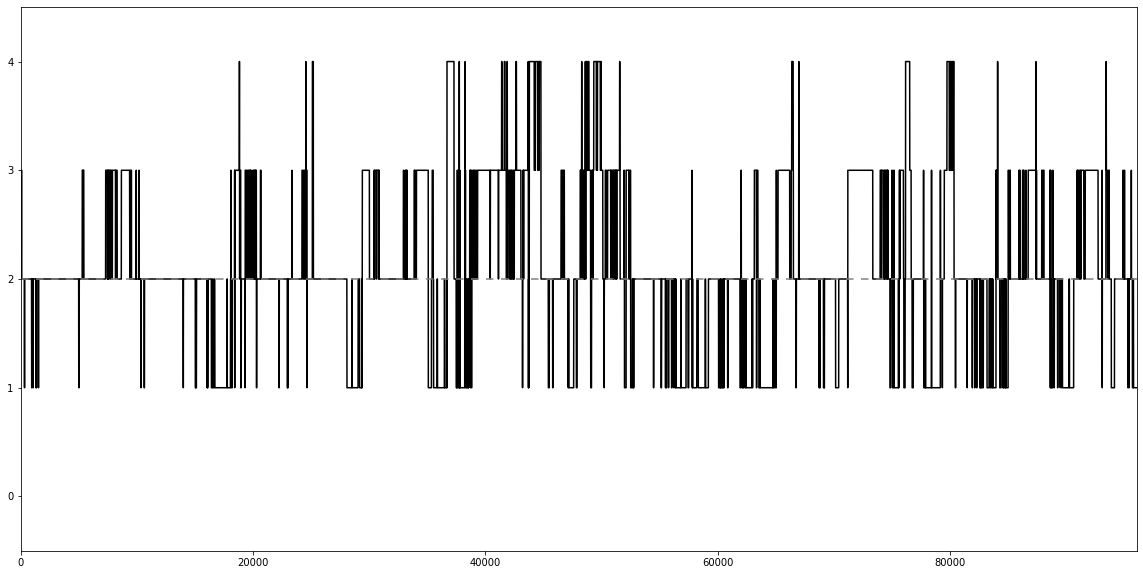

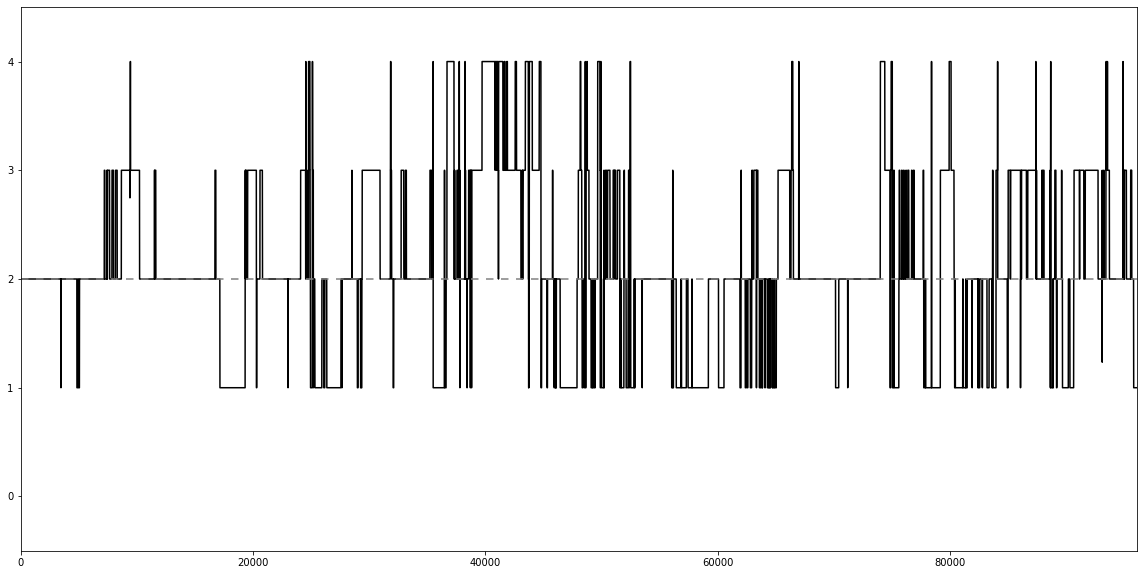

In [29]:
for flattened_bins in flattened_tumors_bins:
    plot_bins(flattened_bins)

In [30]:
def count_tumors_areas(tumors_bins):
    tumors_areas = []
    for tumor_bins in tumors_bins:
        tumor_areas = count_genome_areas(tumor_bins)
        tumors_areas.append(tumor_areas)
        
    return tumors_areas

In [31]:
tumors_areas = count_tumors_areas(tumors_bins)

tumors_areas

[[392.7843333333334,
  66.52323333333334,
  314.75713333333334,
  47.98566666666667,
  37.053733333333334,
  1001.6656666666668,
  212.44380000000004,
  24.505533333333336,
  18.7817,
  464.31359999999995,
  18.52883333333333,
  57.97663333333334,
  93.82263333333333,
  31.227833333333333,
  189.27123333333336,
  162.10853333333336,
  243.33826666666664,
  10.378666666666668,
  275.3524666666667,
  445.5669333333335,
  23.747933333333332,
  72.64020000000001],
 [518.2504333333333,
  1022.5793,
  413.5215666666667,
  714.3256333333333,
  82.75853333333335,
  3039.6803666666665,
  0.0,
  646.2733333333333,
  16.2849,
  585.9402,
  18.8849,
  202.1182,
  50.46826666666667,
  495.6620666666667,
  188.59523333333337,
  0.0,
  7.3833,
  39.73773333333333,
  0.0,
  1113.4629,
  0.0,
  265.8539],
 [1168.2355666666667,
  1066.7033666666673,
  2537.7465000000007,
  1970.9271666666666,
  3832.0228666666667,
  5904.425566666665,
  5542.819133333333,
  3996.846399999999,
  1510.6574666666663,
  305

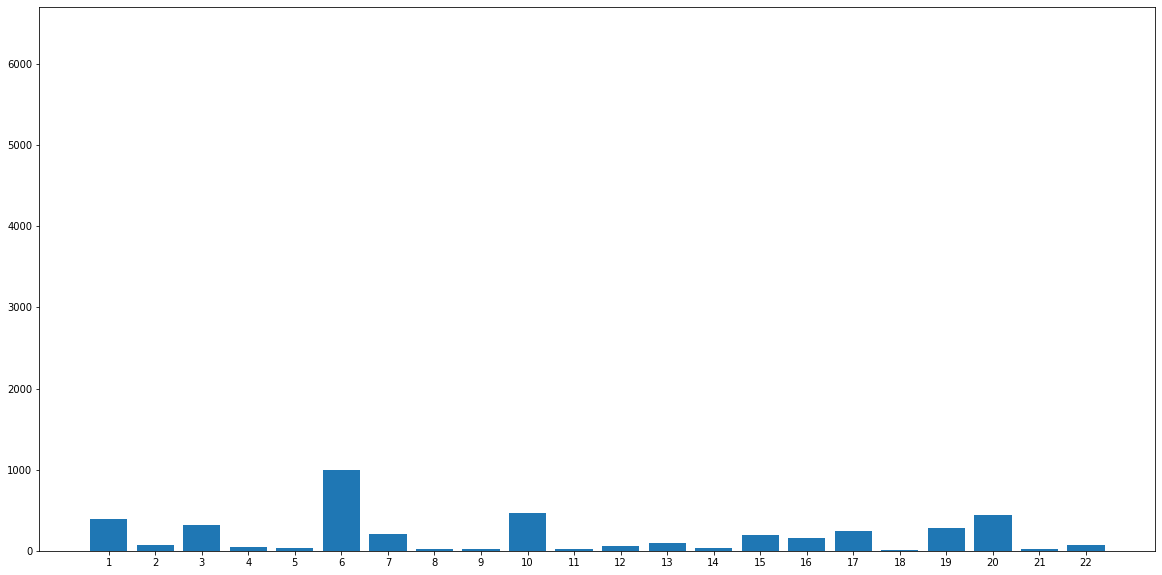

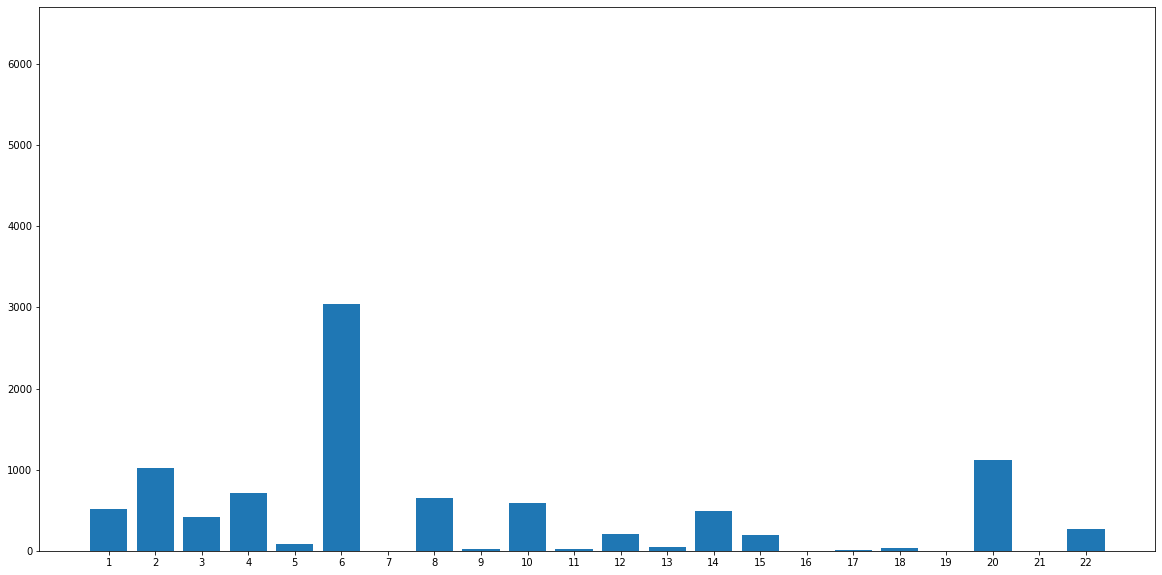

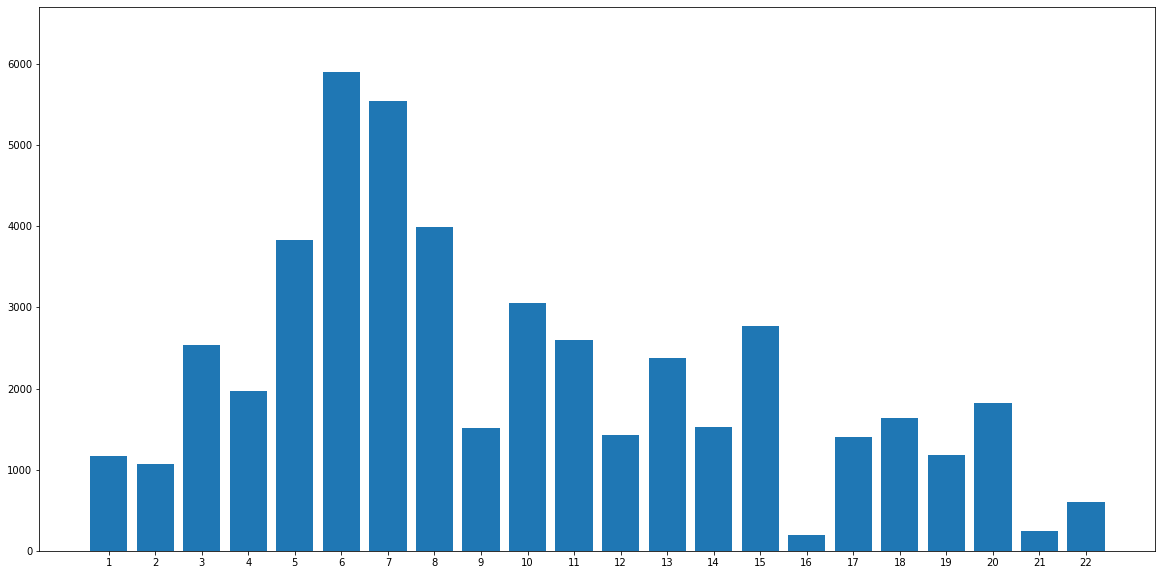

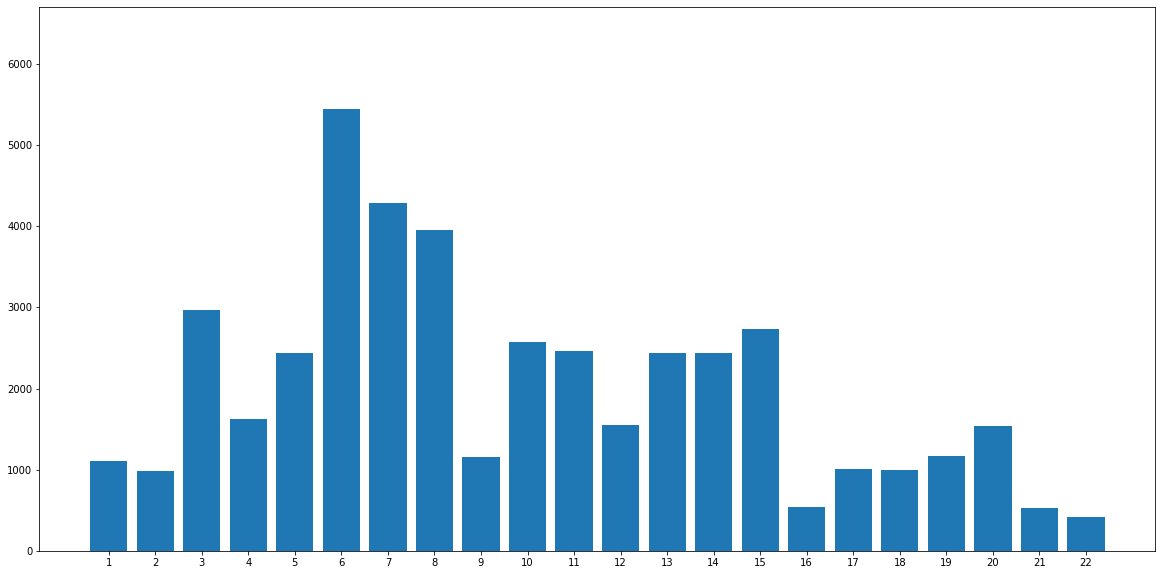

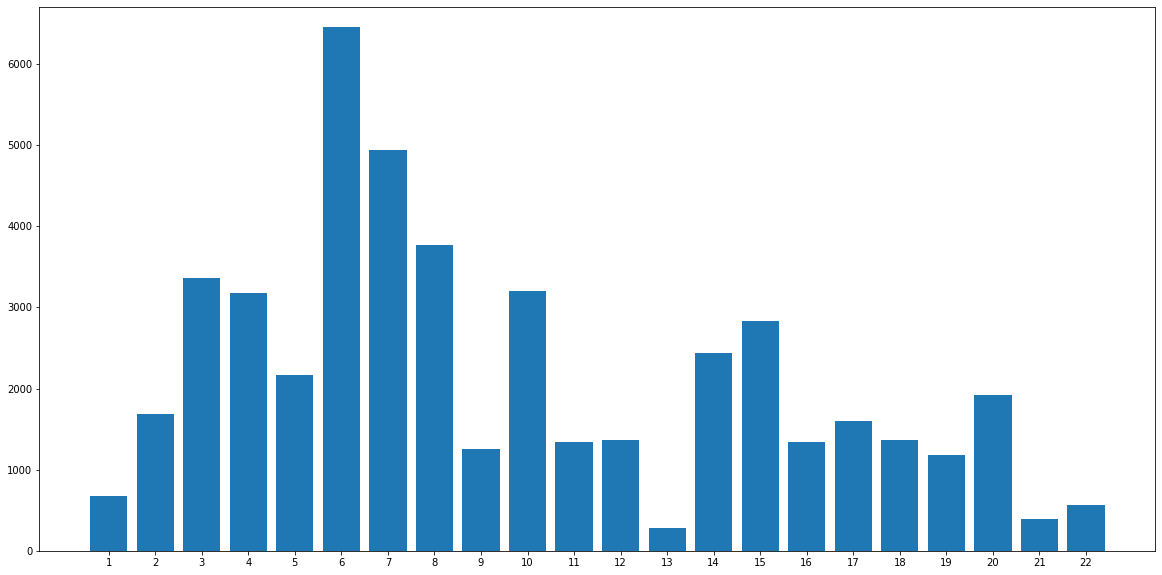

In [39]:
for tumor_areas in tumors_areas:
    visualize_areas_bar(tumor_areas, ylim=[0, 6700])

In [33]:
def count_tumors_relative_areas(tumors_areas, tumors_bins):
    tumors_relative_areas = []
    for idx, tumor_areas in enumerate(tumors_areas):
        tumor_relative_areas = count_relative_areas(tumor_areas, tumors_bins[idx])
        tumors_relative_areas.append(tumor_relative_areas)
        
    return tumors_relative_areas

In [34]:
tumors_relative_areas = count_tumors_relative_areas(tumors_areas, tumors_bins)
    
tumors_relative_areas

[[0.04727215469169977,
  0.00820565355042967,
  0.04768325001262435,
  0.00753070726093325,
  0.006143878848173327,
  0.17560758532024312,
  0.04004595664467484,
  0.005022654915624787,
  0.003989316057774001,
  0.10276972111553784,
  0.004116603717692364,
  0.0129934184969371,
  0.024439341842493703,
  0.008725295706435689,
  0.055374848839477284,
  0.05382089420097389,
  0.08989223002093337,
  0.003987194263029838,
  0.13970191104346358,
  0.21207374266222442,
  0.014796220145379024,
  0.04245482174167154],
 [0.06237217876198499,
  0.12613535216479585,
  0.06264529111750745,
  0.1121038344842017,
  0.013722190902559004,
  0.5329032900888265,
  0.0,
  0.13246020359363256,
  0.0034589847068819033,
  0.12969017264276228,
  0.004195712063985781,
  0.0452976692066338,
  0.01314620126769124,
  0.13849177610133184,
  0.05517707236200508,
  0.0,
  0.002727484299963059,
  0.01526612882571392,
  0.0,
  0.5299680628272251,
  0.0,
  0.155379251899474],
 [0.1405988165443094,
  0.13157806422433296

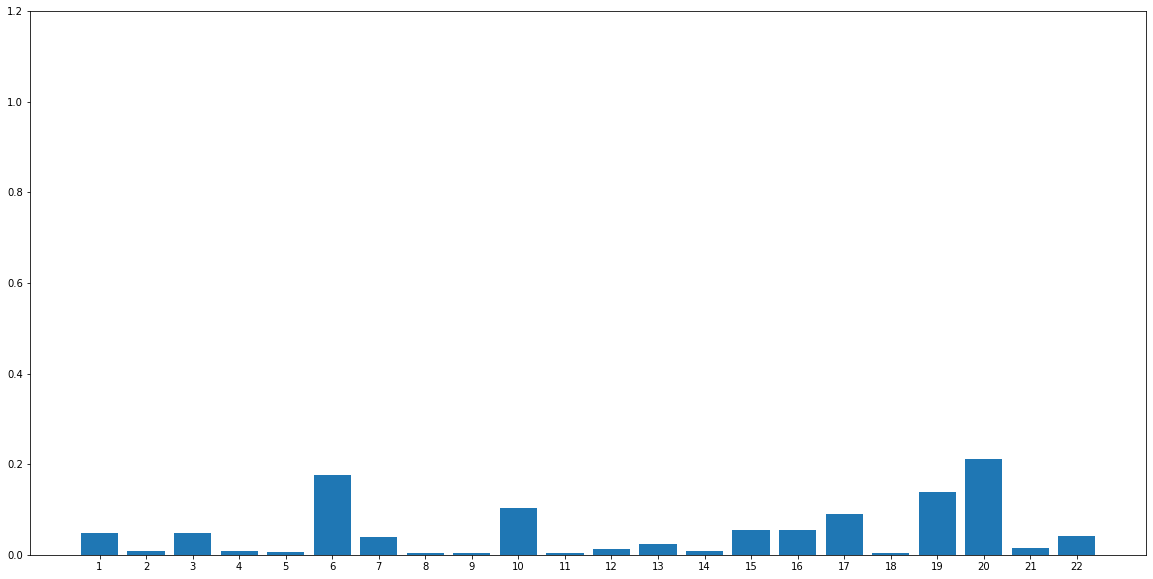

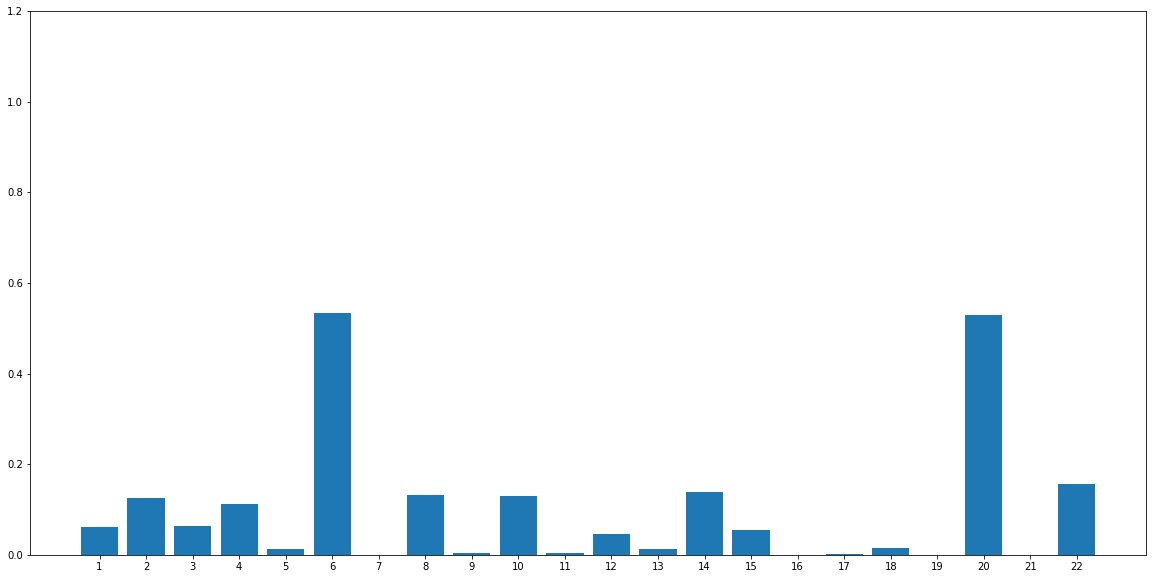

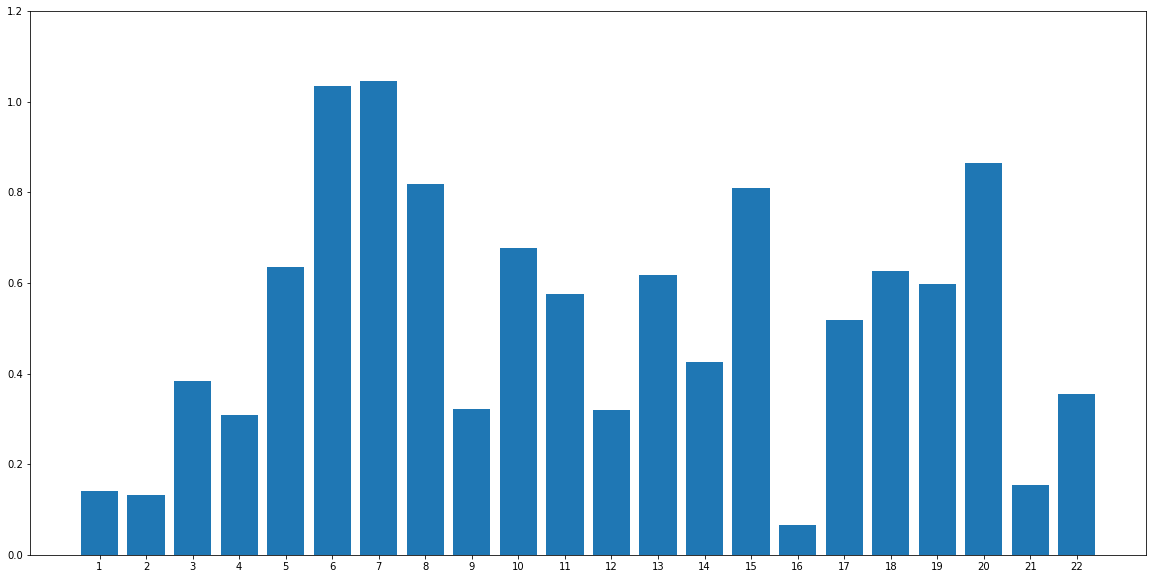

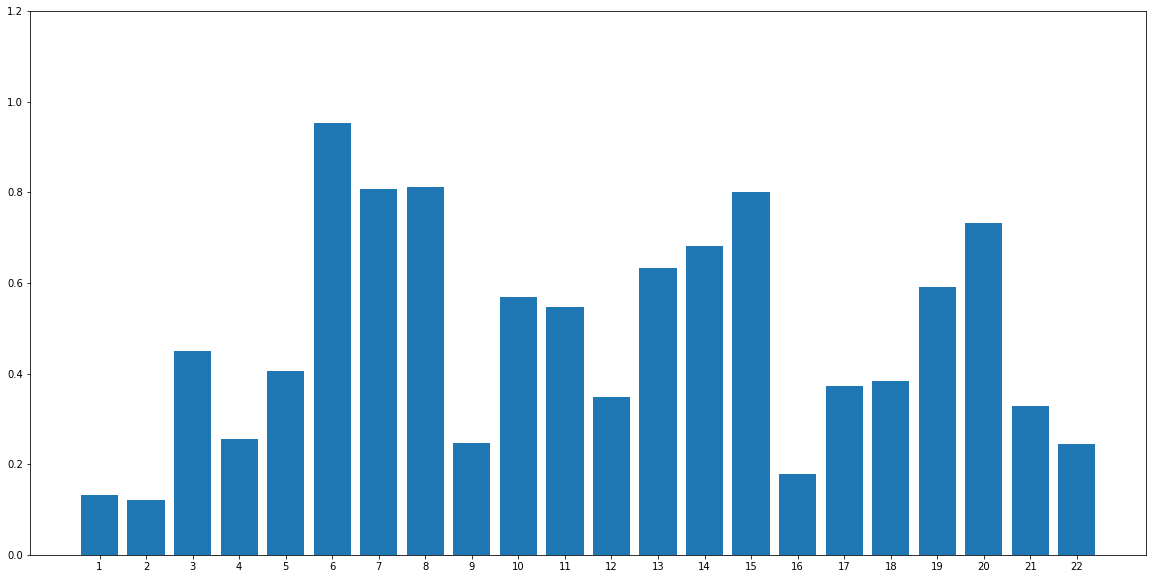

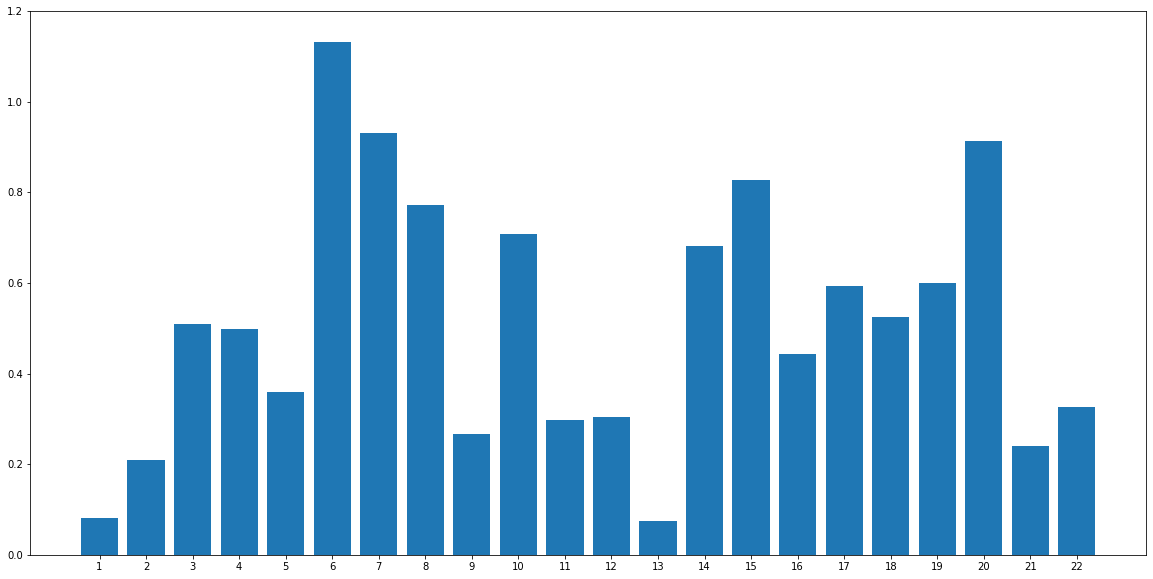

In [40]:
for tumor_relative_areas in tumors_relative_areas:
    visualize_areas_bar(tumor_relative_areas, [0, 1.2])

In [41]:
def count_tumors_cnv_rates(tumors):
    cnv_rates = []
    for tumor in tumors:
        cnv_rate = count_cnv_rate(tumor)
        cnv_rates.append(cnv_rate)
        
    return cnv_rates

In [42]:
cnv_rates = count_tumors_cnv_rates(tumors)

cnv_rates

[0.03786298163550382,
 0.08589494530963099,
 0.4250115967832633,
 0.395492801108438,
 0.41283430794371156]

In [54]:
def visualize_cnv_rates(cnv_rates):
    tumors_names = ['P', 'Rec4', 'Rec5', 'Rec6', 'Rec7']
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(tumors_names, cnv_rates)
    ax.set_ylim([0, 1])

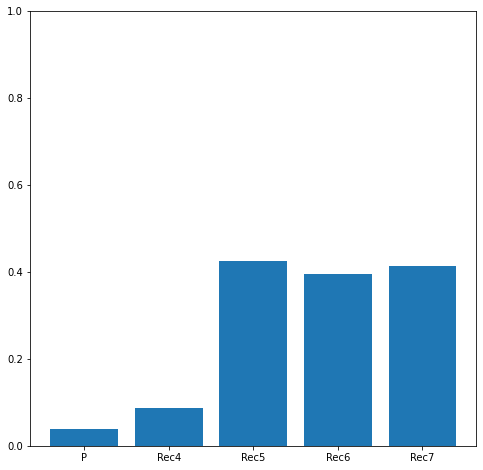

In [55]:
visualize_cnv_rates(cnv_rates)